In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import chain
import string

observations = pd.read_csv('observations.csv')
species = pd.read_csv('species_info.csv')

print("observations Columns", observations.columns)
print("species Columns", species.columns)
print("observations", observations.head(10))
print("species", species.head(10))
print(f"number of species:{species.scientific_name.nunique()}")
print(f"number of categories:{species.category.nunique()}")
print(f"categories:{species.category.unique()}")
print(f"number of conservation statuses:{species.conservation_status.nunique()}")
print(f"unique  conservation statuses:{species.conservation_status.unique()}")
print(f"number of parks:{observations.park_name.nunique()}")
print(f"unique parks:{observations.park_name.unique()}")
species.fillna('no intervention', inplace=True)
species.groupby("conservation_status").size()

maxRows = species['scientific_name'].count()
print('% Missing Data:')
print((1 - species.count() / maxRows) * 100)

conservationCategory = species[species.conservation_status != 'no intervention']\
    .groupby(["conservation_status", "category"])['scientific_name']\
        .nunique()\
            .unstack()
            
conservationCategory
            

observations Columns Index(['scientific_name', 'park_name', 'observations'], dtype='object')
species Columns Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object')
observations                      scientific_name                            park_name  \
0                 Vicia benghalensis  Great Smoky Mountains National Park   
1                     Neovison vison  Great Smoky Mountains National Park   
2                  Prunus subcordata               Yosemite National Park   
3               Abutilon theophrasti                  Bryce National Park   
4           Githopsis specularioides  Great Smoky Mountains National Park   
5  Elymus virginicus var. virginicus               Yosemite National Park   
6                   Spizella pusilla            Yellowstone National Park   
7                  Elymus multisetus  Great Smoky Mountains National Park   
8             Lysimachia quadrifolia               Yosemite National Park   
9         Diph

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


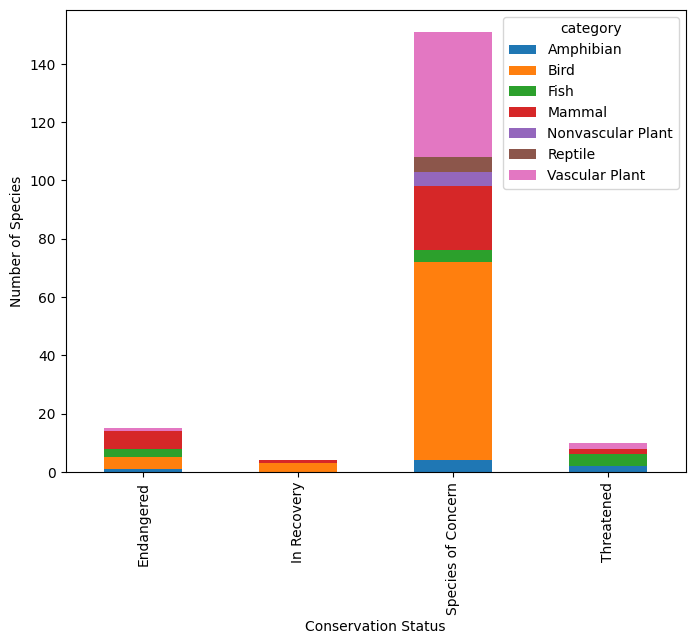

In [54]:

ax = conservationCategory.plot(kind = 'bar', figsize=(8,6), stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

In [55]:
species['is_protected'] = species.conservation_status != 'no intervention'

category_counts = species.groupby(['category', 'is_protected'])\
    .scientific_name.nunique().reset_index()\
        .pivot(columns= 'is_protected', index= 'category', values= 'scientific_name')\
            .reset_index().rename(columns={False: 'not_protected', True: 'protected'})
            
category_counts.columns = ['category', 'not_protected', 'protected']
category_counts


,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [56]:
category_counts['percent_protected'] = category_counts.protected / \
    (category_counts.protected + category_counts.not_protected) * 100
category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


In [57]:
# creating a contingency table for birds and mammals
contingency1 = [[30, 146], [75, 413]]
chi2_contingency(contingency1)

#creating a contingency table for reptiles and mammals
contingency2 = [[30, 146], [5, 73]]
chi2_contingency(contingency2)



Chi2ContingencyResult(statistic=np.float64(4.289183096203645), pvalue=np.float64(0.03835559022969898), dof=1, expected_freq=array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))

In [58]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
        return text
    
common_Names = species[species.category == "Mammal"]\
    .common_names.apply(remove_punctuations)\
        .str.split().tolist()
        
common_Names[:6]

[["Gapper's", 'Red-Backed', 'Vole'],
 ['American', 'Bison,', 'Bison'],
 ['Aurochs,',
  'Aurochs,',
  'Domestic',
  'Cattle',
  '(Feral),',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep,', 'Mouflon,', 'Red', 'Sheep,', 'Sheep', '(Feral)'],
 ['Wapiti', 'Or', 'Elk'],
 ['White-Tailed', 'Deer']]

In [59]:
cleanRows = []
for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[["Gapper's", 'Red-Backed', 'Vole'],
 ['American', 'Bison,', 'Bison'],
 ['Aurochs,', 'Domestic', 'Cattle', '(Feral),', 'Domesticated'],
 ['Domestic', 'Sheep,', 'Mouflon,', 'Red', 'Sheep', '(Feral)'],
 ['Wapiti', 'Or', 'Elk'],
 ['White-Tailed', 'Deer']]

In [60]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

["Gapper's", 'Red-Backed', 'Vole', 'American', 'Bison,', 'Bison']

In [61]:
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))
    
pd.DataFrame(set(words_counted), columns = ['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
194,Shrew,18
155,Bat,17
30,Myotis,17
73,Mouse,15
179,"Bat,",13
37,Chipmunk,13
150,American,12
232,Squirrel,12
129,Eastern,11
144,Vole,11


In [62]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)
species.head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,no intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",no intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",no intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",no intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,no intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,no intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",no intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


In [63]:
species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,no intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",no intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,no intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,no intervention,False,True


In [64]:
bat_observations = observations.merge(species[species.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,no intervention,False,True
2,Nycticeius humeralis,Yellowstone National Park,219,Mammal,Evening Bat,no intervention,False,True
3,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
4,Lasiurus borealis,Yosemite National Park,134,Mammal,"Eastern Red Bat, Red Bat",no intervention,False,True
...,...,...,...,...,...,...,...,...
139,Eptesicus fuscus,Bryce National Park,72,Mammal,Big Brown Bat,Species of Concern,True,True
140,Eptesicus fuscus,Bryce National Park,72,Mammal,"Big Brown Bat, Big Brown Bat",Species of Concern,True,True
141,Myotis leibii,Yellowstone National Park,233,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Lasionycteris noctivagans,Bryce National Park,128,Mammal,Silver-Haired Bat,Species of Concern,True,True


In [65]:
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


In [66]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


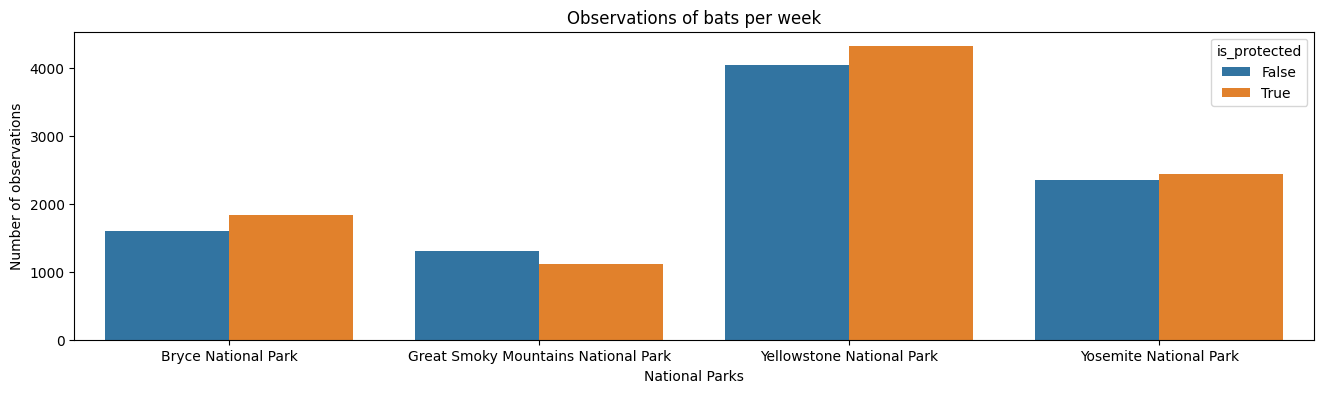

In [70]:
plt.figure(figsize=(16, 4))
sns.barplot(x = obs_by_park.park_name, y = obs_by_park.observations, hue = obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of observations')
plt.title('Observations of bats per week')
plt.show()